In [3]:
import pandas as pd

df = pd.read_csv('../dataset/in.tsv', sep='\t')
df.columns = ["file_name", "list_keys", "pdf2djvu/djvu2hocr", "tesseract", "textract", "pdf2djvu/djvu2hocr_tesseract"]
df = df.dropna(axis = 0)

In [4]:
# Choose which extracted text method to use as input
documents = df["tesseract"].tolist()
df.head()

,file_name,list_keys,pdf2djvu/djvu2hocr,tesseract,textract,pdf2djvu/djvu2hocr_tesseract
0,009fab39d746267b6de8428366fe4b02.pdf,address__post_town address__postcode address__...,"\fAnnual Report 2015-2017 July, 2017\nStepping...",\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...,Charity Name\nNo lif anv)\nStepping Stone Thea...,\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...
1,01c7fd563327947c68abdd9717ef228d.pdf,address__post_town address__postcode address__...,Promoting Independent Living\nCelebrating new\...,54 S ke *\nB\n \nWelcome to our Annual\nReport...,Promoting Independent Living\nAbility\nAbility...,54 S ke *\nB\n \nWelcome to our Annual\nReport...
2,01d804edf76bec4912d2466908a60889.pdf,address__post_town address__postcode address__...,Annual Repor t 8\nAccounts 2017/18\nYear ended...,Annual Report &\nAccounts 2017//183\nYear ende...,Annua Report &\nAccounts 2017/18\nYear ended 3...,Annual Repor t 8\nAccounts 2017/18\nYear ended...
3,01e4461b059e707b7d8276b3d2b80b71.pdf,address__post_town address__postcode address__...,"The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb..."
4,01f91ab7c5e0a5686a0ae1d1d4099b09.pdf,address__post_town address__postcode address__...,KEMPTON GREAT ENGINES TRUST UMITED\nFINANCIAL ...,KEMPTON GREAT ENGINES TRUST LIMITED\nFINANCIAL...,KEMPTON GREAT ENGINES TRUST LIMITED\nFINANCIAL...,KEMPTON GREAT ENGINES TRUST UMITED\nFINANCIAL ...


In [12]:
# Treatment of cleaned text: tokenisation, stemming and lemmatisation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pickle
from rich.progress import track

def cleaning(document):
    # Load English tokenizer, tagger, parser and NER
    nlp = spacy.load("en_core_web_sm")
    # Process whole documents
    document = document.replace("\\n"," ")
    doc = nlp(document)

    # Tokenisation
    token_list = []
    for token in doc:
        token_list.append(token.text)

    # Create list of word tokens after removing stopwords
    filtered_sentence =[] 
    nlp.Defaults.stop_words |= {'total', 'report', 'annual', 'period', 'date', 'para', 'statement', 'number', 'expenditure', 
                       'director', 'result', 'financial', 'review', 'strategy', 'committee', 'executive', 'page',
                       'trustee', 'charity', 'principal', 'signature', 'disclosure', 'performance', 'work',
                       'association', 'trust', 'behalf', 'secretary', 'meeting', 'council', 'year', 'end', 'give',
                       'content', 'message', 'chairman', 'chief', 'officer', 'audit', 'independent', 'charitable',
                       'auditor', 'balance', 'budget', 'end', 'road', 'investment', 'fund', 'cash', 'examiner', 
                       'january', 'february', 'march', 'april', 'may', 'june', 'july', 'asset',  'accounting',
                       'general', 'account', 'name', 'unrestricted', 'accordance', 'continue', 'restrict',
                       'cost', 'value', 'company', 'also', 'scheme', 'tot', 'provide',
                       'august', 'september', 'october', 'november', 'december', 'income', 'fund', 'examination'}
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
            
    doc = nlp(' '.join(filtered_sentence))

    #Lematization
    lemma_word = [] 
    for token in doc:
        lemma_word.append(token.lemma_)

    #Remove punctuation
    doc = ' '.join(word.strip(string.punctuation) for word in lemma_word)
    
    return doc

# Call of the function for all documents
in_documents = [cleaning(document) for document in documents]

In [ ]:
import pickle
with open('in_documents.pkl', 'wb') as f:
    pickle.dump(in_documents, f)

In [8]:
with open('in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)

text = in_documents[2].lower().split(' ')
# from collections import Counter
# word_counts = Counter(text)
# top_words = word_counts.most_common(100)
# print(top_words)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import pickle

with open('in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
trans = vectorizer.fit_transform(in_documents) # input must be a list of string aka whole text in one str

svd = TruncatedSVD(100)
X = svd.fit_transform(trans)

# Kmeans method
true_k = 9
model_k = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model_k.fit(X)

order_centroids = model_k.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


In [ ]:
from fcmeans import FCM
# Soft clustering Method aka c-means clustering
model_c = FCM(n_clusters=6)
model_c.fit(X)

fcm_centers = model_c.centers
fcm_labels = model_c.predict(X)


In [ ]:
with open('model_kmeans.pkl', 'wb') as f:
    pickle.dump(model_k, f)

<AxesSubplot:>

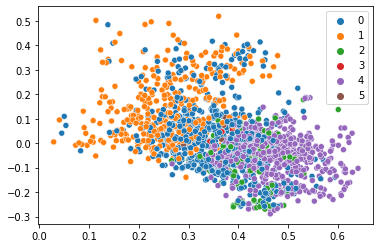

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
# Plot C-means
x = X[:,0]
y = X[:,1]
sns.scatterplot(x=x, y=y, hue=fcm_labels, palette='tab10')
# plot result
# f, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].scatter(X[:,0], X[:,1], alpha=.1)
# axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
# axes[1].scatter(fcm_centers[:,6], fcm_centers[:,6], marker="+", s=500, c='w')
# plt.show()

<AxesSubplot:>

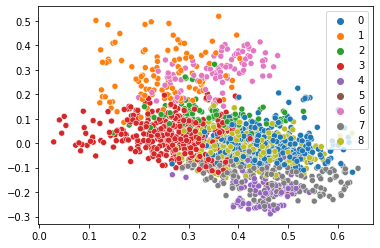

In [ ]:
# Plot K-means
x = X[:,0]
y = X[:,1]
df = pd.DataFrame({'x': x,'y': y, 'model': model_k.labels_})

sns.scatterplot(x=x, y=y, hue=model_k.labels_, palette='tab10')

In [ ]:
import re
pat = r' \w '
string = 'This a is test u which is not a concluding'
x = re.findall(pat, string)
print(x)

[' a ', ' u ', ' a ']


Cluster: 0


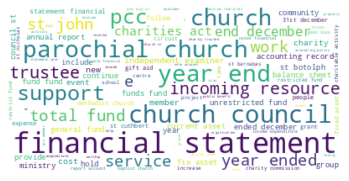

Cluster: 1


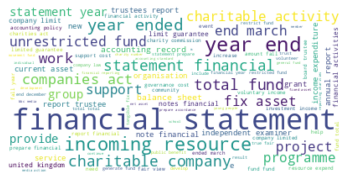

Cluster: 2


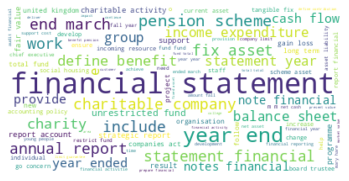

Cluster: 3


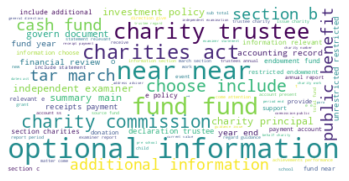

Cluster: 4


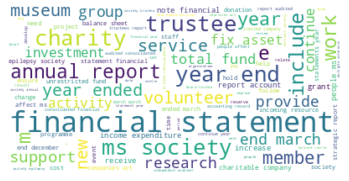

Cluster: 5


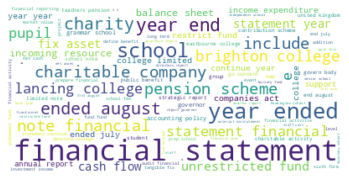

Cluster: 6


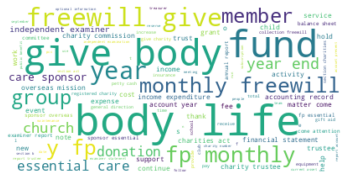

Cluster: 7


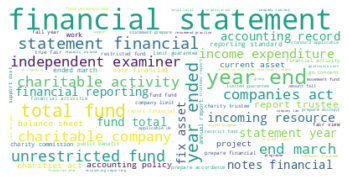

Cluster: 8


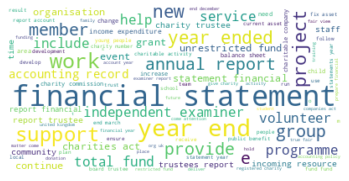

In [11]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

result={'cluster':model_k.labels_,'wiki':in_documents}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print(f'Cluster: {k}')
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [ ]:
import pdftotext

with open("dataset/testpdf.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)

text = [" ".join([page for page in pdf])]
print(text)

['                               COMPANY REGISTRATION NUMBER: 4118489\n                                CHARITY REGISTRATION NUMBER: 1096577\nThe Rationalist Association\nCompany Limited by Guarantee\nUnaudited Financial Statements\n31 December 2017\nJOHN STEWARD\nSteward & Co\nChartered accountant\n5 East Lane\nLondon\nSE164UD\n', "The Rationalist Association\nCompany Limited by Guarantee\nFinancial Statements\nYear ended 31 December 2017\n                                                                    Page\n     Directors' annual report (incorporating the director's report)    1\n     Independent examiner's report to the directors                    6\n     Statement of financial activities (including income and\n     expenditure account)                                              7\n     Statement of financial position                                   8\n     Notes to the financial statements                                10\n", "The Rationalist Association\nCompany Limited b